In [1]:
from __future__ import annotations
from pathlib import Path
import math
from typing import Dict, Tuple, Optional, Iterable
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import shutil


def list_paths_and_stats(
    measurement: str,
    root: str | Path = "../dataset_clean",
    validation_root: str | Path = "../dataset_clean_validation",
    *,
    min_ok: float = 49.75,
    max_ok: float = 50.25,
    treat_missing_as_corrupted: bool = True,
):
    """
    Scan measurement files, attach stats (min/max/mean) from the validation CSVs,
    classify each file as validated or corrupted according to min_ok/max_ok limits,
    and print a final summary of ALL, VALIDATED, and CORRUPTED files.

    Parameters
    ----------
    measurement : str
        Measurement name (e.g., "Freq"). Function searches for */<measurement>/*_<measurement>.csv.xz
    root : str | Path
        Root folder containing the cleaned dataset (default: ../dataset_clean)
    validation_root : str | Path
        Root folder containing per-site per-measurement stats CSVs (default: ../dataset_clean_validation)
    min_ok : float
        Lower bound (inclusive) for valid values of the measurement (default: 49.75)
    max_ok : float
        Upper bound (inclusive) for valid values of the measurement (default: 50.25)
    treat_missing_as_corrupted : bool
        If True, files with missing stats (no row match or missing columns) are marked corrupted.

    Returns
    -------
    all_measurement_paths : list[Path]
        Every matched file path.
    validated_measurement : list[dict]
        Each entry: {'path': Path, 'min': float|None, 'max': float|None, 'mean': float|None}
    corrupted_measurement : list[dict]
        Same shape as validated, plus diagnostic flags:
        {'path', 'min', 'max', 'mean', 'reason': {'stats_missing': bool, 'min_below': bool, 'max_above': bool}}
    """
    root = Path(root)
    validation_root = Path(validation_root)

    # --- 1) Discover all measurement files under root ---
    paths = sorted(root.rglob(f"*/{measurement}/*_{measurement}.csv.xz"))
    
    # Containers for results
    validated = []
    corrupted = []

    # --- 2) Iterate files, read matching stats row, classify ---
    for p in paths:
        # Derive stats CSV location and expected row's file_path (strict, Windows-style, relative to dataset_clean).
        site = p.parents[1].name                  # .../<site>/<measurement>/<file>
        year = p.stem.split("_", 1)[0]            # "<year>_<measurement>.csv.xz" -> "<year>"
        stats_path = validation_root / site / measurement / f"{year}_{measurement}_stats.csv"
        expected_rel = f"dataset_clean\\{site}\\{measurement}\\{year}_{measurement}.csv.xz"

        # Defaults if we cannot find stats
        min_v = max_v = mean_v = None
        stats_missing = True

        # Try load stats and extract the exact row by file_path (strict match, backslashes)
        if stats_path.exists():
            df = pd.read_csv(stats_path, dtype={"file_path": "string"})
            if "file_path" in df.columns:
                fp_series = df["file_path"].astype("string").str.replace("/", "\\", regex=False)
                row = df[fp_series == expected_rel]
                if not row.empty:
                    # Pull columns if present; keep None if absent
                    min_v  = row["min"].iloc[0]  if "min"  in row.columns else None
                    max_v  = row["max"].iloc[0]  if "max"  in row.columns else None
                    mean_v = row["mean"].iloc[0] if "mean" in row.columns else None
                    stats_missing = any(
                        k not in row.columns for k in ("min", "max", "mean")
                    )

                    # If present but NaN, treat as missing
                    for val in (min_v, max_v, mean_v):
                        try:
                            # Coerce pandas NA to Python None-like via float() check
                            _ = float(val)
                        except Exception:
                            stats_missing = True
                            break

        # Classification rules:
        # - If stats are missing and treat_missing_as_corrupted=True => corrupted(stats_missing=True)
        # - Else check thresholds on min and max:
        #     min_ok <= min_v AND max_v <= max_ok => validated
        #     otherwise => corrupted with reason flags
        min_below = max_above = False
        reason = {"stats_missing": False, "min_below": False, "max_above": False}

        if stats_missing and treat_missing_as_corrupted:
            reason["stats_missing"] = True
            corrupted.append({
                "path": p,
                "min": min_v,
                "max": max_v,
                "mean": mean_v,
                "reason": reason
            })
        else:
            # Only check limits if we actually have numeric min/max
            try:
                min_val = float(min_v) if min_v is not None else float("nan")
                max_val = float(max_v) if max_v is not None else float("nan")
            except Exception:
                # Non-numeric stats encountered -> treat as missing
                reason["stats_missing"] = True
                corrupted.append({
                    "path": p,
                    "min": min_v,
                    "max": max_v,
                    "mean": mean_v,
                    "reason": reason
                })
                continue

            # Evaluate limit flags (NaN will fail these comparisons and trigger corruption)
            try:
                min_below = not (min_val >= min_ok)
                max_above = not (max_val <= max_ok)
            except Exception:
                min_below = True
                max_above = True

            if (not min_below) and (not max_above):
                validated.append({"path": p, "min": min_v, "max": max_v, "mean": mean_v})
            else:
                reason["min_below"] = min_below
                reason["max_above"] = max_above
                corrupted.append({
                    "path": p,
                    "min": min_v,
                    "max": max_v,
                    "mean": mean_v,
                    "reason": reason
                })

        # Per-file one-line echo (keeps your current preview; NA if None)
        disp_path = str(p).replace("/", "\\")
        fmt = lambda x: "NA" if x is None else f"{float(x):.6g}"
        #print(f"{disp_path}  -  Min {fmt(min_v)}  Max {fmt(max_v)}  Mean {fmt(mean_v)}")

    # --- 3) Print final summary (ALL, VALIDATED, CORRUPTED) ---
    def _format_entry(d):
        disp = str(d["path"]).replace("/", "\\")
        mmin = "NA" if d["min"]  is None else f"{float(d['min']):.6g}"
        mmax = "NA" if d["max"]  is None else f"{float(d['max']):.6g}"
        mavg = "NA" if d["mean"] is None else f"{float(d['mean']):.6g}"
        return f"{disp}  -  Min {mmin}  Max {mmax}  Mean {mavg}"

    #print("\n=== SUMMARY ===")
    #print(f"ALL ({len(paths)}):")
    #for p in paths:
    #    print(str(p).replace("/", "\\"))

    #print(f"\nVALIDATED ({len(validated)}):")
    #for d in validated:
    #    print(_format_entry(d))

    print(f"Found {len(paths)} file(s) for '{measurement}': CORRUPTED ({len(corrupted)})")
 
    for d in corrupted:
       line = _format_entry(d)
       r = d.get("reason", {})
       flags = []
       if r.get("stats_missing"): flags.append("stats_missing")
       if r.get("min_below"):     flags.append(f"min<{min_ok}")
       if r.get("max_above"):     flags.append(f"max>{max_ok}")
       if flags:
           line += "  [" + ", ".join(flags) + "]"
       print(line)

    # --- 4) Return the three lists the caller may want to use programmatically ---
    return paths, validated, corrupted

def clean_and_backup(
    data_path: str | Path,
    min_ok: float,
    max_ok: float,
    value_col: str | None = None,
    plot_before: bool = True,
    plot_after: bool = True,
):
    """
    ONE-SHOT CLEANER:
    1) (optional) Plot original full series (with time-local red shading where outliers occur).
    2) Print original min/mean/max, original missing, and #outliers to remove.
    3) Build cleaned data + *_stats + *_missing in memory (EXACT schemas).
    4) Move ORIGINAL files (data, stats, missing) into ROOT/backup/<relative path>.
    5) Write CLEANED files into their ORIGINAL locations (overwriting originals).
    6) (optional) Plot cleaned series (same shading), print new min/mean/max, new missing,
       and verify: new_missing == old_missing + outliers_removed.

    Guarantees:
      - Backup tree has ONLY the original files.
      - Original locations end up with ONLY the cleaned files.
    """

    # ---------- Load original data ----------
    p = Path(data_path).resolve()
    assert p.exists(), f"Data file not found: {p}"
    df = pd.read_csv(p, compression="xz")

    # Infer timestamp and measurement (enforce single measurement)
    ts_col = next(c for c in df.columns if pd.to_datetime(df[c], errors="coerce").notna().mean() > 0.99)
    ts = pd.to_datetime(df[ts_col], errors="coerce")
    assert ts.notna().any(), f"Timestamp column '{ts_col}' could not be parsed."

    work = df.drop(columns=[ts_col]).set_index(ts).sort_index()
    numeric_cols = [c for c in work.columns if pd.api.types.is_numeric_dtype(work[c])]
    if value_col is None:
        assert len(numeric_cols) == 1, f"Multiple numeric columns found; set value_col. Found: {numeric_cols}"
        value_col = numeric_cols[0]
    else:
        assert value_col in work.columns and value_col in numeric_cols, f"value_col='{value_col}' invalid."
    s = work[value_col]

    # Outlier + plotting masks
    mask = (s >= min_ok) & (s <= max_ok)
    out_mask = s.notna() & ~mask

    # ---------- Before: plot + stats + outliers ----------
    if plot_before:
        ax = s.plot(figsize=(20, 4), linewidth=0.6, zorder=1)
        yl = ax.get_ylim()
        pad = 0.02 * (yl[1] - yl[0]) if np.isfinite(yl).all() else 0.0
        yl = (yl[0] - pad, yl[1] + pad); ax.set_ylim(*yl)

        # time-local shading only where outliers occur
        ax.fill_between(s.index, yl[0], yl[1], where=out_mask.values, alpha=0.12, color="red", step="pre", zorder=0)

        # guide lines + dots
        ax.axhline(min_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.axhline(max_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.scatter(mdates.date2num(s.index[out_mask].to_pydatetime()),s[out_mask].to_numpy(),s=10, marker=".", alpha=0.8, color="red", zorder=3)

        ax.set_title(str(p).replace("/", "\\"))
        ax.set_xlabel("Time"); ax.set_ylabel(value_col); ax.grid(True, linestyle=":", linewidth=0.5)
        plt.tight_layout(); plt.show()

    orig_min, orig_mean, orig_max = s.min(skipna=True), s.mean(skipna=True), s.max(skipna=True)
    orig_missing = int(s.isna().sum())
    outliers = int(((s < min_ok) | (s > max_ok)).sum(skipna=True))
    print(f"ORIGINAL  min={orig_min}, mean={orig_mean}, max={orig_max} | missing={orig_missing} | outliers_to_remove={outliers}")

    # ---------- Clean ----------
    cleaned = s.mask((s < min_ok) | (s > max_ok))
    cleaned_df2 = cleaned.sort_index().reset_index()
    cleaned_df2.columns = [ts_col, value_col]           # EXACT 2 columns, no index
    s_clean = cleaned_df2[value_col]

    # ---------- Resolve project root + destination paths ----------
    # ROOT := parent of the 'dataset_clean' directory containing the data file
    dc_dir = next(par for par in p.parents if par.name == "dataset_clean")
    root = dc_dir.parent

    # Relative path under dataset_clean
    rel_after_dc = p.relative_to(dc_dir).as_posix()  # e.g., EPI_ChipPress/Freq/2023_Freq.csv.xz
    base_name = p.name
    base_no_multi = base_name[:-len(".csv.xz")] if base_name.lower().endswith(".csv.xz") else p.stem

    # Final target paths under ROOT
    data_dst    = p  # cleaned data replaces original
    stats_dst   = (root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_stats.csv").resolve()
    missing_dst = (root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_missing.csv").resolve()

    # Backup targets under ROOT/backup (mirror both trees)
    backup_root = (root / "backup").resolve()
    data_bak    = (backup_root / "dataset_clean"            / rel_after_dc).resolve()
    stats_bak   = (backup_root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_stats.csv").resolve()
    missing_bak = (backup_root / "dataset_clean_validation" / Path(rel_after_dc).parent / f"{base_no_multi}_missing.csv").resolve()

    # Ensure parents exist for backup & targets
    for q in (data_bak.parent, stats_bak.parent, missing_bak.parent, stats_dst.parent, missing_dst.parent):
        q.mkdir(parents=True, exist_ok=True)

    # ---------- Build CLEAN stats (EXACT schema & order) ----------
    rel_path_str = (Path(dc_dir.name) / rel_after_dc).as_posix().replace("/", "\\")
    file_path_str = rel_path_str
    stats_cols = ["file_path","min","max","mean","std","q01","q05","q25","q50","q75","q95","q99"]
    stats_row = {
        "file_path": file_path_str,
        "min": s_clean.min(skipna=True),
        "max": s_clean.max(skipna=True),
        "mean": s_clean.mean(skipna=True),
        "std": s_clean.std(skipna=True),
        "q01": s_clean.quantile(0.01),
        "q05": s_clean.quantile(0.05),
        "q25": s_clean.quantile(0.25),
        "q50": s_clean.quantile(0.50),
        "q75": s_clean.quantile(0.75),
        "q95": s_clean.quantile(0.95),
        "q99": s_clean.quantile(0.99),
    }
    stats_df = pd.DataFrame([[stats_row[c] for c in stats_cols]], columns=stats_cols)

    # ---------- Build CLEAN missing (EXACT schema & order) ----------
    dt = pd.to_datetime(cleaned_df2[ts_col])
    diffs = np.diff(dt.astype("int64").to_numpy()); med_ns = np.median(diffs) if len(diffs) else 1e9
    step_s = float(med_ns / 1e9) if med_ns > 0 else 1.0

    is_na = s_clean.isna().to_numpy()
    n_total = len(s_clean); n_nans = int(is_na.sum()); n_zeros = int((s_clean == 0).sum(skipna=True))

    # leading/trailing NaNs
    lead = int(np.argmax(~is_na)) if n_total else 0
    if lead == 0 and n_total and is_na[0]: lead = n_total
    rev = is_na[::-1]
    trail = int(np.argmax(~rev)) if n_total else 0
    if trail == 0 and n_total and rev[0]: trail = n_total
    middle = n_nans - lead - trail

    # run-length encode NaN gaps
    gaps, c = [], 0
    for v in is_na:
        if v: c += 1
        elif c: gaps.append(c); c = 0
    if c: gaps.append(c)

    def bucketize(gaps, step):
        bins = {
            "1_step": (0,0), "5s_30s": (5,30), "30s_1m": (30,60), "1m_15m": (60,900),
            "15m_1h": (900,3600), "1h_24h": (3600,86400), "1d_7d": (86400,604800),
            "1w_1mo": (604800,2592000), "1mo_inf": (2592000, np.inf),
        }
        cnt = {k:0 for k in bins}; steps={k:0 for k in bins}
        for L in gaps:
            if L == 1: cnt["1_step"]+=1; steps["1_step"]+=1; continue
            dur = L*step; placed=False
            for k,(lo,hi) in list(bins.items())[1:]:
                if lo <= dur < hi: cnt[k]+=1; steps[k]+=L; placed=True; break
            if not placed: cnt["5s_30s"]+=1; steps["5s_30s"]+=L
        return cnt, steps

    cnt, stp = bucketize(gaps, step_s)
    def pct(steps): return round(100.0 * (steps / n_nans), 2) if n_nans > 0 else 0.0

    miss_cols = [
        "file_path","n_total","n_nans","n_zeros","n_nans_start","n_nans_end","n_nans_middle",
        "n_missing_gaps","missing_gap_total_sec",
        "nan_1_step_count","nan_1_step_steps","nan_1_step_pct",
        "nan_5s_30s_count","nan_5s_30s_steps","nan_5s_30s_pct",
        "nan_30s_1m_count","nan_30s_1m_steps","nan_30s_1m_pct",
        "nan_1m_15m_count","nan_1m_15m_steps","nan_1m_15m_pct",
        "nan_15m_1h_count","nan_15m_1h_steps","nan_15m_1h_pct",
        "nan_1h_24h_count","nan_1h_24h_steps","nan_1h_24h_pct",
        "nan_1d_7d_count","nan_1d_7d_steps","nan_1d_7d_pct",
        "nan_1w_1mo_count","nan_1w_1mo_steps","nan_1w_1mo_pct",
        "nan_1mo_inf_count","nan_1mo_inf_steps","nan_1mo_inf_pct",
    ]
    miss_row = {
        "file_path": file_path_str,
        "n_total": n_total,
        "n_nans": n_nans,
        "n_zeros": n_zeros,
        "n_nans_start": lead,
        "n_nans_end": trail,
        "n_nans_middle": middle,
        "n_missing_gaps": len(gaps),
        "missing_gap_total_sec": int(n_nans * step_s),
        "nan_1_step_count": cnt["1_step"], "nan_1_step_steps": stp["1_step"], "nan_1_step_pct": pct(stp["1_step"]),
        "nan_5s_30s_count": cnt["5s_30s"], "nan_5s_30s_steps": stp["5s_30s"], "nan_5s_30s_pct": pct(stp["5s_30s"]),
        "nan_30s_1m_count": cnt["30s_1m"], "nan_30s_1m_steps": stp["30s_1m"], "nan_30s_1m_pct": pct(stp["30s_1m"]),
        "nan_1m_15m_count": cnt["1m_15m"], "nan_1m_15m_steps": stp["1m_15m"], "nan_1m_15m_pct": pct(stp["1m_15m"]),
        "nan_15m_1h_count": cnt["15m_1h"], "nan_15m_1h_steps": stp["15m_1h"], "nan_15m_1h_pct": pct(stp["15m_1h"]),
        "nan_1h_24h_count": cnt["1h_24h"], "nan_1h_24h_steps": stp["1h_24h"], "nan_1h_24h_pct": pct(stp["1h_24h"]),
        "nan_1d_7d_count": cnt["1d_7d"], "nan_1d_7d_steps": stp["1d_7d"], "nan_1d_7d_pct": pct(stp["1d_7d"]),
        "nan_1w_1mo_count": cnt["1w_1mo"], "nan_1w_1mo_steps": stp["1w_1mo"], "nan_1w_1mo_pct": pct(stp["1w_1mo"]),
        "nan_1mo_inf_count": cnt["1mo_inf"], "nan_1mo_inf_steps": stp["1mo_inf"], "nan_1mo_inf_pct": pct(stp["1mo_inf"]),
    }
    missing_df = pd.DataFrame([[miss_row[c] for c in miss_cols]], columns=miss_cols)

    # ---------- BACKUP originals ONLY ----------
    # originals must exist for all three (we crash if not present)
    assert stats_dst.exists(),   f"Stats file not found: {stats_dst}"
    assert missing_dst.exists(), f"Missing file not found: {missing_dst}"

    # Move originals to backup (no renaming); at this moment, original locations are empty
    for src, dst in ((data_dst, data_bak), (stats_dst, stats_bak), (missing_dst, missing_bak)):
        dst.parent.mkdir(parents=True, exist_ok=True)
        shutil.move(str(src), str(dst))

    # ---------- WRITE CLEAN to original targets ONLY ----------
    # (No clean copies in backup.)
    cleaned_df2.to_csv(data_dst, index=False, compression="xz")  # data
    stats_df.to_csv(stats_dst, index=False)                      # stats
    missing_df.to_csv(missing_dst, index=False)                  # missing

    # ---------- After: plot + stats + consistency check ----------
    if plot_after:
        ax = cleaned_df2.set_index(ts_col)[value_col].plot(figsize=(20, 4), linewidth=0.6, zorder=1)
        yl = ax.get_ylim()
        pad = 0.02 * (yl[1] - yl[0]) if np.isfinite(yl).all() else 0.0
        yl = (yl[0] - pad, yl[1] + pad); ax.set_ylim(*yl)

        # reuse original outlier mask to shade when outliers were present
        ax.fill_between(s.index, yl[0], yl[1], where=out_mask.values, alpha=0.12, color="red", step="pre", zorder=0)
        ax.axhline(min_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.axhline(max_ok, linestyle="--", linewidth=0.8, zorder=2)
        ax.scatter(mdates.date2num(s.index[out_mask].to_pydatetime()),s[out_mask].to_numpy(),s=10, marker=".", alpha=0.5, color="red", zorder=3)

        ax.set_title("(cleaned) " + str(p).replace("/", "\\"))
        ax.set_xlabel("Time"); ax.set_ylabel(value_col); ax.grid(True, linestyle=":", linewidth=0.5)
        plt.tight_layout(); plt.show()

    new_min, new_mean, new_max = s_clean.min(skipna=True), s_clean.mean(skipna=True), s_clean.max(skipna=True)
    new_missing = int(s_clean.isna().sum())
    print(f"CLEANED   min={new_min}, mean={new_mean}, max={new_max} | missing={new_missing}")
    print(f"CHECK     old_missing({orig_missing}) + outliers({outliers}) == new_missing({new_missing})"
          f" -> {'OK' if (orig_missing + outliers) == new_missing else 'MISMATCH!'}")



### Outlier Filter

In [ ]:
# I1, I2, I3, IN, I1_f, I2_f, I3_f, IN_f, I_sys, I_sys_f
# P1, P2, P3, P_total, P1_f, P2_f, P3_f
# PF1, PF1_h, PF2, PF2_h, PF3, PF3_h, PF_total

In [10]:
measurements_others = ["Freq", "Freq_f","LoadType1", "LoadType1_f","LoadType2", "LoadType2_f","LoadType3", "LoadType3_f","Angle_U1", "Angle_U1_f",
    "Angle_U2", "Angle_U2_f","Angle_U3", "Angle_U3_f","Angle_UI1","Angle_UI1_f","Angle_UI2", "Angle_UI2_f","Angle_UI3", "Angle_UI3_f","OpHours",]

measurements_u_hramonics = [
    "U12_h2", "U12_h3", "U12_h4", "U12_h5", "U12_h7", "U12_h9","U12_h11", "U12_h13", "U12_h15", "U12_h17", "U12_h19", "U12_h21","U12_h23", "U12_h25", "U12_h27", "U12_h29", "U12_h31",
    "U1_h2","U1_h3", "U1_h4", "U1_h5", "U1_h7", "U1_h9","U1_h11", "U1_h13", "U1_h15", "U1_h17", "U1_h19", "U1_h21","U1_h23", "U1_h25", "U1_h27", "U1_h29", "U1_h31",
    "U23_h2", "U23_h3", "U23_h4", "U23_h5", "U23_h7", "U23_h9","U23_h11", "U23_h13", "U23_h15", "U23_h17", "U23_h19", "U23_h21","U23_h23", "U23_h25", "U23_h27", "U23_h29", "U23_h31",
    "U2_h2", "U2_h3", "U2_h4", "U2_h5", "U2_h7", "U2_h9","U2_h11", "U2_h13", "U2_h15", "U2_h17", "U2_h19", "U2_h21","U2_h23", "U2_h25", "U2_h27", "U2_h29", "U2_h31",
    "U31_h2", "U31_h3", "U31_h4", "U31_h5", "U31_h7", "U31_h9","U31_h11", "U31_h13", "U31_h15", "U31_h17", "U31_h19", "U31_h21","U31_h23", "U31_h25", "U31_h27", "U31_h29", "U31_h31",
    "U3_h2", "U3_h3", "U3_h4", "U3_h5", "U3_h7", "U3_h9","U3_h11", "U3_h13", "U3_h15", "U3_h17", "U3_h19", "U3_h21","U3_h23", "U3_h25", "U3_h27", "U3_h29", "U3_h31",]

measurements_i_harmonics = [
    "I1_h2","I1_h3", "I1_h4", "I1_h5", "I1_h7", "I1_h9","I1_h11", "I1_h13", "I1_h15", "I1_h17", "I1_h19", "I1_h21","I1_h23", "I1_h25", "I1_h27", "I1_h29", "I1_h31",
    "I2_h2","I2_h3", "I2_h4", "I2_h5", "I2_h7", "I2_h9","I2_h11", "I2_h13", "I2_h15", "I2_h17", "I2_h19", "I2_h21","I2_h23", "I2_h25", "I2_h27", "I2_h29", "I2_h31",
    "I3_h2","I3_h3", "I3_h4", "I3_h5", "I3_h7", "I3_h9","I3_h11", "I3_h13", "I3_h15", "I3_h17", "I3_h19", "I3_h21","I3_h23", "I3_h25", "I3_h27", "I3_h29", "I3_h31",
    "IN_h2","IN_h3", "IN_h4", "IN_h5", "IN_h7", "IN_h9","IN_h11", "IN_h13", "IN_h15", "IN_h17", "IN_h19", "IN_h21","IN_h23", "IN_h25", "IN_h27", "IN_h29", "IN_h31",
]



In [23]:
# 0.) Set Hardcoded measurement limits: {(min, max): [measurement names]}
LIMITS_BY_RANGE = {
    (49.0, 51.0): [
        "Freq", "Freq_f",
    ],

    (-1.0, 1.0): [
        "LoadType1", "LoadType1_f",
        "LoadType2", "LoadType2_f",
        "LoadType3", "LoadType3_f",
    ],

    (-180.0, 180.0): [
        "Angle_U1", "Angle_U1_f",
        "Angle_U2", "Angle_U2_f",
        "Angle_U3", "Angle_U3_f",
        "Angle_UI1", "Angle_UI1_f",
        "Angle_UI2", "Angle_UI2_f",
        "Angle_UI3", "Angle_UI3_f",
    ],

    (2000.0, 25000.0): [
        "OpHours",
    ],

    (0.0, 100.0): [
        # U12 harmonics
        "U12_h2", "U12_h3", "U12_h4", "U12_h5", "U12_h7", "U12_h9",
        "U12_h11", "U12_h13", "U12_h15", "U12_h17", "U12_h19", "U12_h21",
        "U12_h23", "U12_h25", "U12_h27", "U12_h29", "U12_h31",

        # U1 harmonics
        "U1_h2", "U1_h3", "U1_h4", "U1_h5", "U1_h7", "U1_h9",
        "U1_h11", "U1_h13", "U1_h15", "U1_h17", "U1_h19", "U1_h21",
        "U1_h23", "U1_h25", "U1_h27", "U1_h29", "U1_h31",

        # U23 harmonics
        "U23_h2", "U23_h3", "U23_h4", "U23_h5", "U23_h7", "U23_h9",
        "U23_h11", "U23_h13", "U23_h15", "U23_h17", "U23_h19", "U23_h21",
        "U23_h23", "U23_h25", "U23_h27", "U23_h29", "U23_h31",

        # U2 harmonics
        "U2_h2", "U2_h3", "U2_h4", "U2_h5", "U2_h7", "U2_h9",
        "U2_h11", "U2_h13", "U2_h15", "U2_h17", "U2_h19", "U2_h21",
        "U2_h23", "U2_h25", "U2_h27", "U2_h29", "U2_h31",

        # U31 harmonics
        "U31_h2", "U31_h3", "U31_h4", "U31_h5", "U31_h7", "U31_h9",
        "U31_h11", "U31_h13", "U31_h15", "U31_h17", "U31_h19", "U31_h21",
        "U31_h23", "U31_h25", "U31_h27", "U31_h29", "U31_h31",

        # U3 harmonics
        "U3_h2", "U3_h3", "U3_h4", "U3_h5", "U3_h7", "U3_h9",
        "U3_h11", "U3_h13", "U3_h15", "U3_h17", "U3_h19", "U3_h21",
        "U3_h23", "U3_h25", "U3_h27", "U3_h29", "U3_h31",
    ],
    (0.0, 150.0): [
        "I1_h2","I1_h3", "I1_h4", "I1_h5", "I1_h7", "I1_h9","I1_h11", "I1_h13", "I1_h15", "I1_h17", "I1_h19", "I1_h21","I1_h23", "I1_h25", "I1_h27", "I1_h29", "I1_h31",
        "I2_h2","I2_h3", "I2_h4", "I2_h5", "I2_h7", "I2_h9","I2_h11", "I2_h13", "I2_h15", "I2_h17", "I2_h19", "I2_h21","I2_h23", "I2_h25", "I2_h27", "I2_h29", "I2_h31",
        "I3_h2","I3_h3", "I3_h4", "I3_h5", "I3_h7", "I3_h9","I3_h11", "I3_h13", "I3_h15", "I3_h17", "I3_h19", "I3_h21","I3_h23", "I3_h25", "I3_h27", "I3_h29", "I3_h31",
        "IN_h2","IN_h3", "IN_h4", "IN_h5", "IN_h7", "IN_h9","IN_h11", "IN_h13", "IN_h15", "IN_h17", "IN_h19", "IN_h21","IN_h23", "IN_h25", "IN_h27", "IN_h29", "IN_h31",
    ],
}


In [26]:
from pathlib import Path

def process_measurement(
    meas_list,
    LIMITS_BY_RANGE,
    list_paths_and_stats,
    clean_and_backup,
    script_dir=None,
    testmode=True,
):
    """
    Process measurements in meas_list using limit bounds from LIMITS_BY_RANGE.
    - If testmode is True, do not modify or back up any files; only simulate and log actions.
    """

    if script_dir is None:
        script_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

    for meas in meas_list:
        # --- find min/max for this measurement from LIMITS_BY_RANGE ---
        min_ok = max_ok = None
        for (lo, hi), names in LIMITS_BY_RANGE.items():
            if meas in names:
                min_ok, max_ok = lo, hi
                break

        if min_ok is None or max_ok is None:
            print(f"[SKIP] No limits found for '{meas}' in LIMITS_BY_RANGE.")
            continue

        print(f"\n=== Processing '{meas}' with limits [{min_ok}:{max_ok}] ===")

        # --- 1) list all + validated/corrupted with correct limits for this measurement ---
        paths, validated, corrupted = list_paths_and_stats(meas, min_ok=min_ok, max_ok=max_ok)

        # --- 2) try to fix all corrupted files for this measurement ---
        subset = corrupted
        total = len(subset)
        bad_files = []

        if total == 0:
            print(f"No corrupted files detected for '{meas}'.")
            continue

        for i, entry in enumerate(subset, start=1):
            path_str = str(entry["path"]).replace("/", "\\")
            print(f"[{i}/{total}] {path_str}")
            try:
                if testmode:
                    print(f"  -> TESTMODE: Would clean and backup: {path_str} (limits: {min_ok}, {max_ok})")
                else:
                    clean_and_backup(
                        path_str,
                        min_ok=min_ok,
                        max_ok=max_ok,
                        plot_before=False,
                        plot_after=False,
                    )
            except EOFError:
                print(f"  -> Skipped (corrupted/compressed EOF): {path_str}")
                bad_files.append(path_str)
            except Exception as e:
                print(f"  -> Skipped ({type(e).__name__}): {path_str}")
                bad_files.append(path_str)

        # --- 3) write out any files we couldn't read for this measurement ---
        if bad_files:
            out = script_dir / f"corrupted_files_{meas}.txt"
            msg = f"\nSkipped {len(bad_files)} files due to read errors. List saved to: {out}"
            if not testmode:
                out.write_text("\n".join(bad_files), encoding="utf-8")
                print(msg)
            else:
                print(f"\nTESTMODE: {len(bad_files)} files would be listed as unreadable at {out}")
        else:
            print("\nAll files processed without read errors.")

# Example usage:
process_measurement(
    meas_list=measurements_i_harmonics,
    LIMITS_BY_RANGE=LIMITS_BY_RANGE,
    list_paths_and_stats=list_paths_and_stats,
    clean_and_backup=clean_and_backup,
    script_dir=None,   # or provide your path
    testmode=False      # True for dry-run, False for actual processing
)



=== Processing 'I1_h2' with limits [0.0:150.0] ===
Found 11 file(s) for 'I1_h2': CORRUPTED (6)
..\dataset_clean\TEC_Chiron800\I1_h2\2024_I1_h2.csv.xz  -  Min 0  Max 552.7  Mean 1.05893  [max>150.0]
..\dataset_clean\TEC_DMF3008\I1_h2\2024_I1_h2.csv.xz  -  Min 0  Max 260.8  Mean 1.68521  [max>150.0]
..\dataset_clean\TEC_DMU125MB\I1_h2\2024_I1_h2.csv.xz  -  Min 0  Max 751.1  Mean 0.673408  [max>150.0]
..\dataset_clean\TEC_E110\I1_h2\2024_I1_h2.csv.xz  -  Min 0  Max 216.4  Mean 0.428962  [max>150.0]
..\dataset_clean\TEC_E30D2\I1_h2\2024_I1_h2.csv.xz  -  Min 0  Max 2163.5  Mean 1.06525  [max>150.0]
..\dataset_clean\TEC_MV2400R\I1_h2\2024_I1_h2.csv.xz  -  Min 0  Max 3276.7  Mean 0.490689  [max>150.0]
[1/6] ..\dataset_clean\TEC_Chiron800\I1_h2\2024_I1_h2.csv.xz
ORIGINAL  min=0.0, mean=1.0589261057196266, max=552.7 | missing=594456 | outliers_to_remove=6
CLEANED   min=0.0, mean=1.058690391548508, max=130.3 | missing=594462
CHECK     old_missing(594456) + outliers(6) == new_missing(594462) -> 

Mean 0.003656559261663046 Min 0.0 - Max 158.25


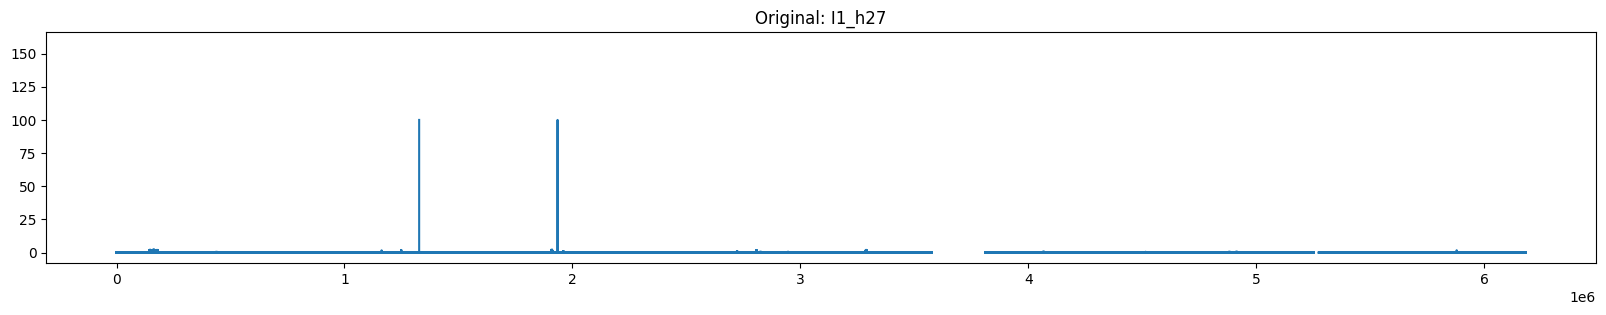

In [25]:
df = pd.read_csv(r"..\dataset_clean\EPI_WashingMachine\I1_h27\2023_I1_h27.csv.xz")
col = df.select_dtypes("number").columns[0]  # first numeric series
print(f"Mean {df[col].mean()} Min {df[col].min()} - Max {df[col].max()}")
plt.figure(figsize=(20, 3))
df[col].plot(title=f"Original: {col}")
plt.show()

In [ ]:
# Assume LIMITS_BY_RANGE is already defined like:
# LIMITS_BY_RANGE = { (min_val, max_val): [ "MeasA", "MeasB", ... ], ... }

script_dir = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()

for meas in ["U1"]:
    # --- find min/max for this measurement from LIMITS_BY_RANGE (no helper function) ---
    min_ok = max_ok = None
    for (lo, hi), names in LIMITS_BY_RANGE.items():
        if meas in names:
            min_ok, max_ok = lo, hi
            break

    if min_ok is None or max_ok is None:
        print(f"[SKIP] No limits found for '{meas}' in LIMITS_BY_RANGE.")
        continue

    print(f"\n=== Processing '{meas}' with limits [{min_ok}:{max_ok}] ===")

    
    # --- 1) list all + validated/corrupted with correct limits for this measurement ---
    paths, validated, corrupted = list_paths_and_stats(meas, min_ok=min_ok, max_ok=max_ok)

    
    
    # --- 2) try to fix all corrupted files for this measurement ---
    subset = corrupted  # process ALL corrupted files for this measurement
    total = len(subset)
    bad_files = []

    if total == 0:
        print(f"No corrupted files detected for '{meas}'.")
        continue

    for i, entry in enumerate(subset, start=1):
        path_str = str(entry["path"]).replace("/", "\\")
        print(f"[{i}/{total}] {path_str}")
        try:
            clean_and_backup(
                path_str,
                min_ok=min_ok,   # use the measurement-specific limits
                max_ok=max_ok,
                plot_before=False,
                plot_after=False,
            )
        except EOFError:
            print(f"  -> Skipped (corrupted/compressed EOF): {path_str}")
            bad_files.append(path_str)
        except Exception as e:
            print(f"  -> Skipped ({type(e).__name__}): {path_str}")
            bad_files.append(path_str)

    # --- 3) write out any files we couldn't read for this measurement ---
    if bad_files:
        out = script_dir / f"corrupted_files_{meas}.txt"
        out.write_text("\n".join(bad_files), encoding="utf-8")
        print(f"\nSkipped {len(bad_files)} files due to read errors. List saved to: {out}")
    else:
        print("\nAll files processed without read errors.")



=== Processing 'LoadType1' with limits [-1.0:1.0] ===
Found 11 file(s) for 'LoadType1':

CORRUPTED (1):
[1/1] ..\dataset_clean\TEC_48S\LoadType1\2024_LoadType1.csv.xz
ORIGINAL  min=0.0, mean=0.9999954285400814, max=1.0 | missing=5886983 | outliers_to_remove=0
  -> Skipped (AssertionError): ..\dataset_clean\TEC_48S\LoadType1\2024_LoadType1.csv.xz

Skipped 1 files due to read errors. List saved to: d:\EnergyDataset\scripts\corrupted_files_LoadType1.txt


In [ ]:
"Chip Press": EPI_ChipPress
"Chip Saw": EPI_ChipSaw
"High Temperature Oven": EPI_HighTempOven
"Pick and Place Machine": EPI_PickAndPlace
"Pump Station 1": EPI_PumpStation1
"Pump Station 2": EPI_PumpStation2
"ScreenPrinter": EPI_ScreenPrinter
"Solder Oven": EPI_SolderOven
"Main Terminal": EPI_TotalLoad
"Vacuum Soldering System": EPI_VacuumSoldering
"Washing Machine": EPI_WashingMachine
"Lathe machine 2": TEC_48S
"Water chiller": TEC_CFST161
"Lathe milling machine": TEC_CTX800TC
"5-axis milling machine 1": TEC_Chiron800
"5-axis milling machine 2": TEC_DMF3008
"5-axis milling machine 3": TEC_DMU125MB
"Milling machine": TEC_DNG50evo
"Lathe machine": TEC_E110
"Lathe machine 1": TEC_E30D2
"Liquid cooler": TEC_JWA24
"Wire EDM machine": TEC_MV2400R